In [152]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from sklearn import metrics
import math
from tensorflow.keras import initializers

tf.random.set_seed(42)
np.random.seed(42)

In [250]:
X = []
Y = []

for i in range(0,50):
    print("Loading file #"+str(i))
    df = pd.read_csv("./data/raw/synthetic_basic/Synthetic_Basic_"+str(i)+".csv")
    degradation_rate = df.iloc[0].Degradation_rate_per_yr
    
    # Reducing to day by day data, picking the max
#    df['Day'] = df['Unnamed: 0'].apply(lambda x: x.split(' ')[0])
#    df = df.groupby('Day', as_index=False).Power.max()

    # Reducing to hour by hour data, picking the mean
    df['Time'] = df['Unnamed: 0'].apply(lambda x: x.split(':')[0])
    df = df.groupby('Time', as_index=False).Power.max()
   
    # Option 1: sampling n random period of 3 years from each time series
#    n_samples = 100
#    for i in range(0, n_samples):
#        first_index = int(np.random.uniform(0,len(df)-27000))
#        X.append([x for x in df.Power[first_index:first_index+27000]])
#        Y.append(degradation_rate)
#        Y.append([degradation_rate]*len(X[-1]))
        
    # Option 2: taking the 5-year time series as a single sample
    X.append([x/1827 for x in df.Power])
    # If taking a single value for the degradation rate
#    Y.append(degradation_rate)
    # If taking a normalized value representing degradation
    Y.append([np.power(1+degradation_rate,i/365.25/24)-1 for i in range(0,len(df))])

Loading file #0
Loading file #1
Loading file #2
Loading file #3
Loading file #4
Loading file #5
Loading file #6
Loading file #7
Loading file #8
Loading file #9
Loading file #10
Loading file #11
Loading file #12
Loading file #13
Loading file #14
Loading file #15
Loading file #16
Loading file #17
Loading file #18
Loading file #19
Loading file #20
Loading file #21
Loading file #22
Loading file #23
Loading file #24
Loading file #25
Loading file #26
Loading file #27
Loading file #28
Loading file #29
Loading file #30
Loading file #31
Loading file #32
Loading file #33
Loading file #34
Loading file #35
Loading file #36
Loading file #37
Loading file #38
Loading file #39
Loading file #40
Loading file #41
Loading file #42
Loading file #43
Loading file #44
Loading file #45
Loading file #46
Loading file #47
Loading file #48
Loading file #49


In [251]:
# For option 1 of data selection
#dataset_size = len(X)
#X = np.array(X)
#Y = np.array(Y)
#shuffled_indices = np.random.permutation(dataset_size)
#train_indices = shuffled_indices[:int(dataset_size*0.7)]
#valid_indices = shuffled_indices[int(dataset_size*0.7):int(dataset_size*0.85)]
#test_indices = shuffled_indices[int(dataset_size*0.85):]

#X_train = np.array([x for x in X[train_indices]])
#X_valid = np.array([x for x in X[valid_indices]])
#X_test = np.array([x for x in X[test_indices]])
#Y_train = np.array([x for x in Y[train_indices]])
#Y_valid = np.array([x for x in Y[valid_indices]])
#Y_test = np.array([x for x in Y[test_indices]])

# For option 2 of data selection
X_train = np.array([x for x in X[:30]])
X_valid = np.array([x for x in X[30:40]])
X_test = np.array([x for x in X[40:]])
Y_train = np.array([x for x in Y[:30]])
Y_valid = np.array([x for x in Y[30:40]])
Y_test = np.array([x for x in Y[40:]])

X_train = X_train.reshape((X_train.shape[0],X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1], 1))
X_valid = X_valid.reshape((X_valid.shape[0],X_valid.shape[1], 1))

In [65]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [256]:
#expon_lr = ExponentialLearningRate(factor=1.05)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=100)

run_index = 3
run_logdir = os.path.join(os.curdir, "wavenet_logs_0807", "run_{:03d}".format(run_index))
checkpoint_cb = keras.callbacks.ModelCheckpoint("wavenet_model_0807.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [264]:
initializer = tf.keras.initializers.lecun_normal()

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384) * 2:
    model.add(keras.layers.Conv1D(
        filters=20,
        kernel_size=2,
        padding="causal",
        activation="relu",
        dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10,
                              kernel_size=1,
                              activation="relu"))
model.add(keras.layers.Dense(1))
model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(X_train,
                    Y_train,
                    epochs=5000,
                    validation_data=(X_valid, Y_valid))
#                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/5000
1/1 [==============================] - 11s 11s/step - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 6.3574e-04 - val_root_mean_squared_error: 0.0252
Epoch 2/5000
1/1 [==============================] - 1s 1s/step - loss: 8.8498e-04 - root_mean_squared_error: 0.0297 - val_loss: 4.7093e-04 - val_root_mean_squared_error: 0.0217
Epoch 3/5000
1/1 [==============================] - 1s 1s/step - loss: 6.8143e-04 - root_mean_squared_error: 0.0261 - val_loss: 3.3702e-04 - val_root_mean_squared_error: 0.0184
Epoch 4/5000
1/1 [==============================] - 1s 1s/step - loss: 5.0578e-04 - root_mean_squared_error: 0.0225 - val_loss: 2.4894e-04 - val_root_mean_squared_error: 0.0158
Epoch 5/5000
1/1 [==============================] - 1s 1s/step - loss: 3.7576e-04 - root_mean_squared_error: 0.0194 - val_loss: 2.0661e-04 - val_root_mean_squared_error: 0.0144
Epoch 6/5000
1/1 [==============================] - 1s 1s/step - loss: 2.9113e-04 - root_mean_squared_error: 0.0171 -

1/1 [==============================] - 1s 1s/step - loss: 1.0417e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.0989e-04 - val_root_mean_squared_error: 0.0105
Epoch 48/5000
1/1 [==============================] - 1s 1s/step - loss: 1.0315e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.1270e-04 - val_root_mean_squared_error: 0.0106
Epoch 49/5000
1/1 [==============================] - 1s 1s/step - loss: 1.0186e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.1677e-04 - val_root_mean_squared_error: 0.0108
Epoch 50/5000
1/1 [==============================] - 1s 1s/step - loss: 1.0093e-04 - root_mean_squared_error: 0.0100 - val_loss: 1.2058e-04 - val_root_mean_squared_error: 0.0110
Epoch 51/5000
1/1 [==============================] - 1s 1s/step - loss: 1.0048e-04 - root_mean_squared_error: 0.0100 - val_loss: 1.2226e-04 - val_root_mean_squared_error: 0.0111
Epoch 52/5000
1/1 [==============================] - 1s 1s/step - loss: 1.0004e-04 - root_mean_squared_error: 0.0100 - val_l

1/1 [==============================] - 1s 1s/step - loss: 9.1035e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.0808e-04 - val_root_mean_squared_error: 0.0104
Epoch 94/5000
1/1 [==============================] - 1s 1s/step - loss: 9.0970e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.0713e-04 - val_root_mean_squared_error: 0.0104
Epoch 95/5000
1/1 [==============================] - 1s 1s/step - loss: 9.0926e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.0686e-04 - val_root_mean_squared_error: 0.0103
Epoch 96/5000
1/1 [==============================] - 1s 1s/step - loss: 9.0880e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.0738e-04 - val_root_mean_squared_error: 0.0104
Epoch 97/5000
1/1 [==============================] - 1s 1s/step - loss: 9.0821e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.0806e-04 - val_root_mean_squared_error: 0.0104
Epoch 98/5000
1/1 [==============================] - 1s 1s/step - loss: 9.0786e-05 - root_mean_squared_error: 0.0095 - val_l

Epoch 139/5000
1/1 [==============================] - 1s 1s/step - loss: 8.5861e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.0437e-04 - val_root_mean_squared_error: 0.0102
Epoch 140/5000
1/1 [==============================] - 1s 1s/step - loss: 8.5838e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.0423e-04 - val_root_mean_squared_error: 0.0102
Epoch 141/5000
1/1 [==============================] - 1s 1s/step - loss: 8.5824e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.0471e-04 - val_root_mean_squared_error: 0.0102
Epoch 142/5000
1/1 [==============================] - 1s 1s/step - loss: 8.5820e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.0331e-04 - val_root_mean_squared_error: 0.0102
Epoch 143/5000
1/1 [==============================] - 1s 1s/step - loss: 8.5814e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.0517e-04 - val_root_mean_squared_error: 0.0103
Epoch 144/5000
1/1 [==============================] - 1s 1s/step - loss: 8.5806e-05 - root_mean_squared_e

Epoch 185/5000
1/1 [==============================] - 1s 1s/step - loss: 8.5510e-05 - root_mean_squared_error: 0.0092 - val_loss: 1.0398e-04 - val_root_mean_squared_error: 0.0102
Epoch 186/5000
1/1 [==============================] - 1s 1s/step - loss: 8.5505e-05 - root_mean_squared_error: 0.0092 - val_loss: 1.0386e-04 - val_root_mean_squared_error: 0.0102
Epoch 187/5000
1/1 [==============================] - 1s 1s/step - loss: 8.5502e-05 - root_mean_squared_error: 0.0092 - val_loss: 1.0444e-04 - val_root_mean_squared_error: 0.0102
Epoch 188/5000
1/1 [==============================] - 1s 1s/step - loss: 8.5499e-05 - root_mean_squared_error: 0.0092 - val_loss: 1.0379e-04 - val_root_mean_squared_error: 0.0102
Epoch 189/5000
1/1 [==============================] - 1s 1s/step - loss: 8.5495e-05 - root_mean_squared_error: 0.0092 - val_loss: 1.0409e-04 - val_root_mean_squared_error: 0.0102
Epoch 190/5000
1/1 [==============================] - 1s 1s/step - loss: 8.5490e-05 - root_mean_squared_e

KeyboardInterrupt: 

In [267]:
prediction = model.predict(X_test)

In [92]:
prediction.shape

(10, 43824, 1)

Text(0.5, 1.0, 'Normalized decay vs time (hours)')

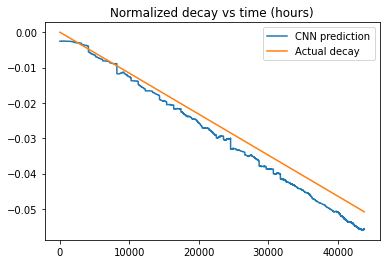

In [272]:
plt.figure()
plt.plot([np.log(x+1) for x in prediction[6]])
plt.plot([np.log(x+1) for x in Y_test[6]])
plt.legend(['CNN prediction','Actual decay'])
plt.title("Normalized decay vs time (hours)")

In [68]:
y_pred = []
for x in prediction:
    y_pred.append(np.mean(x))

In [50]:
y_pred = np.array(y_pred)

In [70]:
mse = sklearn.metrics.mean_squared_error(y_pred, Y_test)
math.sqrt(mse)

0.002893060343155977

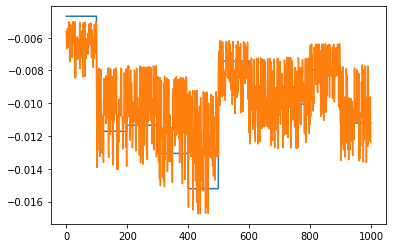

In [75]:
plt.figure()
plt.plot(Y_test)
plt.plot((y_pred-np.mean(y_pred))*100+y_pred)
plt.show()

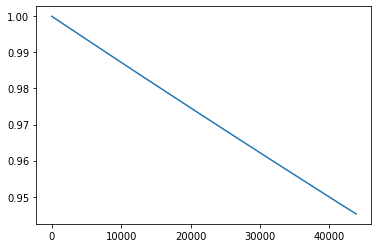

In [233]:
plt.plot([np.power(1+degradation_rate,i/365.25/24) for i in range(0,len(df))])

In [225]:
for i in range(0, len(Y_train)):
    print(len(Y_train[i]))

43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824


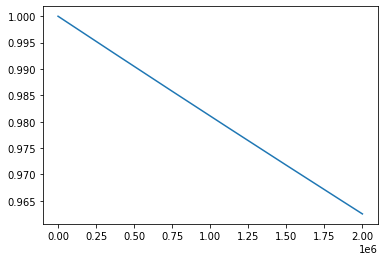

In [213]:
t = [x for x in range(0,2000000)]
power = [np.power(1-0.01,i/365.25/24/60) for i in t]

plt.plot(t,power)